<a href="https://colab.research.google.com/github/mreskandarinasab/Detecting-COVID-19-from-X-Ray-Images-with-a-CNN/blob/main/Detecting_COVID_19_from_X_Ray.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Download Dataset

First, we download the dataset of X-ray Images that have Covid from GitHub

In [ ]:
!wget https://github.com/ieee8023/covid-chestxray-dataset/archive/refs/heads/master.zip
!unzip /content/master.zip


Then we download the dataset of healthy X-ray Images from kaggle

In [ ]:
from google.colab import files
files.upload()

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!ls ~/.kaggle

In [ ]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia
!unzip /content/chest-xray-pneumonia.zip

Separate Covid cases

In [ ]:
import pandas as pd
import shutil
import os

In [ ]:
FILE_PATH = "/content/covid-chestxray-dataset-master/metadata.csv"
IMAGES_PATH = "/content/covid-chestxray-dataset-master/images"

In [ ]:
df = pd.read_csv(FILE_PATH)

In [ ]:
!mkdir Dataset
!mkdir Dataset/Covid
TARGET_DIR = "/content/Dataset/Covid"

In [ ]:
#there is 196 COVID-19 positive images
cnt = 0 
for (i,row) in df.iterrows(): 
  if row["finding"]=="Pneumonia/Viral/COVID-19"and row["view"]=="PA": 
    filename = row["filename"] 
    image_path = os.path.join(IMAGES_PATH,filename) 
    image_copy_path = os.path.join(TARGET_DIR,filename) 
    shutil.copy2(image_path,image_copy_path) 
    print("Moving image ",cnt) 
    cnt += 1 

In [ ]:
import random 
!mkdir Dataset/Normal
KAGGLE_FILE_PATH = "/content/chest_xray/train/NORMAL" 
TARGET_NORMAL_DIR ="/content/Dataset/Normal" 

In [ ]:
image_names = os.listdir(KAGGLE_FILE_PATH)
random.shuffle(image_names)

In [ ]:
for i in range(196): 
  image_name = image_names[i] 
  image_path = os.path.join(KAGGLE_FILE_PATH,image_name) 
  target_path = os.path.join(TARGET_NORMAL_DIR,image_name) 
  shutil.copy2(image_path,target_path) 
  print("Copying image ",i) 

In [ ]:
# count the number of images in the respective classes 0- covid and 1- Healthey 
ROOT_DIR = "/content/Dataset" 
number_of_images = {} 
for dir in os.listdir(ROOT_DIR): 
  number_of_images[dir] = len(os.listdir(os.path.join(ROOT_DIR, dir)) ) 
number_of_images.items() 

dict_items([('Normal', 196), ('Covid', 196)])

# we will split the data such that 
* 70 % for Train Data 
* 15 % for Validation 
* 15 % for testing

In [ ]:
import numpy as np
import math 
def dataFolder(p, split): 
  # we create a training folder 
  if not os.path.exists("./"+p): 
    os.mkdir("./"+p) 
    for dir in os.listdir(ROOT_DIR): 
      os.makedirs("./"+p+"/"+dir) 
      for img in np.random.choice(a=os.listdir(os.path.join(ROOT_DIR, dir) ) , size= (math.floor(split*number_of_images[dir])-1) , replace=False ): 
        O = os.path.join(ROOT_DIR,dir,img) 
        D = os.path.join("./"+p,dir) 
        shutil.copy(O,D) 
        os.remove(O) 
  else: print( f"{p}Folder exsist") 

In [ ]:
dataFolder("train", 0.7)
dataFolder("val", 0.15)
dataFolder("test", 0.15)

In [ ]:
from keras.preprocessing.image import ImageDataGenerator 
from keras.applications.mobilenet_v2 import preprocess_input

def preprocessingImagesl(path): 
  """
  input : Path 
  output : Pre processed images 
  """
  image_data = ImageDataGenerator(zoom_range= 0.2, shear_range= 0.2, preprocessing_function = preprocess_input, horizontal_flip= True) #data Augmentation 
  image = image_data.flow_from_directory(directory = path, target_size = (224,224), batch_size = 32, class_mode = 'binary') 
  return image 

path = "/content/train" 
train_data = preprocessingImagesl(path) 
train_data.class_indices

Found 272 images belonging to 2 classes.


{'Covid': 0, 'Normal': 1}

In [ ]:
def preprocessingImages2(path): 
  """
  input : Path 
  output : Pre processed images 
  """
  image_data = ImageDataGenerator(preprocessing_function = preprocess_input) 
  image = image_data.flow_from_directory(directory = path, target_size = (224,224), batch_size = 32, class_mode = 'binary') 
  return image 

path = "/content/test" 
test_data  = preprocessingImages2(path) 

path = "/content/val" 
val_data  = preprocessingImages2(path) 

Found 56 images belonging to 2 classes.
Found 56 images belonging to 2 classes.


# Model Training

In [ ]:
import numpy as np 
import matplotlib.pyplot as plt 
from keras.layers import Flatten, Dense 
from keras.models import Model, load_model 
from keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input 
import keras

In [ ]:
base_model = MobileNetV2(input_shape= (224,224,3), include_top= False) 

In [ ]:
X  = Flatten()(base_model.output) 
X  = Dense(units=1 , activation='sigmoid')(X) 
model = Model(base_model.input, X) 
model.summary() 

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
____________________________________________________________________________________________

In [ ]:
model.compile(optimizer='rmsprop', loss= keras.losses.binary_crossentropy, metrics=['accuracy']) 
## Call Back 
from keras.callbacks import ModelCheckpoint, EarlyStopping 
# model Check point 
mc = ModelCheckpoint(filepath="bestmodel.h5", monitor='accuracy', verbose= 1, save_best_only= True ) 
# Early Stopping 
es = EarlyStopping(monitor="accuracy", min_delta= 0.01, patience= 5, verbose= 1)
cb =[mc,es]

In [ ]:
hist = model.fit(train_data,
                           steps_per_epoch= 8,
                           epochs= 30,
                           validation_data= val_data,
                           validation_steps= 16,
                           callbacks= cb) 

Epoch 1/30
8/8 [==============================] - 22s 2s/step - loss: 2.6385 - accuracy: 0.7734 - val_loss: 24.3087 - val_accuracy: 0.6071

Epoch 00001: accuracy improved from -inf to 0.77344, saving model to bestmodel.h5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/30
8/8 [==============================] - 10s 1s/step - loss: 0.0285 - accuracy: 0.9833

Epoch 00002: accuracy improved from 0.77344 to 0.98333, saving model to bestmodel.h5
Epoch 3/30
8/8 [==============================] - 10s 1s/step - loss: 0.1560 - accuracy: 0.9833

Epoch 00003: accuracy did not improve from 0.98333
Epoch 4/30
8/8 [==============================] - 10s 1s/step - loss: 0.0467 - accuracy: 0.9917

Epoch 00004: accuracy improved from 0.98333 to 0.99167, saving model to bestmodel.h5
Epoch 5/30
8/8 [==============================] - 10s 1s/step - loss: 0.0379 - accuracy: 0.9875

Epoch 00005: accuracy did not improve from 0.99167
Epoch 6/30
8/8 [==============================] - 10s 1s/step - loss: 0.0082 - accuracy: 0.9958

Epoch 00006: accuracy improved from 0.99167 to 0.99583, saving model to bestmodel.h5
Epoch 7/30
8/8 [==============================] - 10s 1s/step - loss: 0.0113 - accuracy: 0.9958

Epoch 00007: accuracy did not improve from 0.99583
Epoch 8/30

In [ ]:
# load the best fit model 
model = load_model("/content/bestmodel.h5") 
acc = model.evaluate(test_data)[1] 
print(f"our model accuracy is {acc*100} % ") 

2/2 [==============================] - 2s 614ms/step - loss: 5.8252e-11 - accuracy: 1.0000
our model accuracy is 100.0 % 


In [ ]:
h = hist.history
h.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

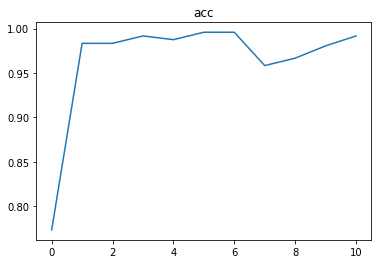

In [ ]:
plt.plot(h['accuracy']) 
plt.title("acc") 
plt.show() 

Covid-19 Positive


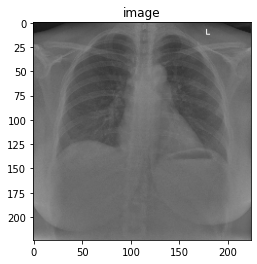

In [ ]:
from keras.preprocessing import image

# path for the image to see if it predics correct class 
path = "/content/Dataset/Covid/f6575117.jpg"
img = image.load_img(path, target_size=(224,224) ) 

i = image.img_to_array(img)/255
input_arr = np.array([i]) 
input_arr.shape 

pred = model.predict(input_arr)

if pred >= 0.5 :
  pred = 1
else :
  pred = 0 

if pred == 0: 
  print("Covid-19 Positive") 
else: print("Covid-19 Negative") 

plt.imshow(input_arr[0])
plt.title("image")
plt.show()